In [26]:
# General Libs
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
from google.colab import drive
# Montar o Google Drive
drive.mount('/content/drive')

im_shape = (250,250)

#TRAINING_DIR = '/content/drive/MyDrive/chest_xray_pequeno/train'
#TEST_DIR = '/content/drive/MyDrive/chest_xray_pequeno/test'
TRAINING_DIR = '/content/drive/MyDrive/chest_xray/train'
TEST_DIR = '/content/drive/MyDrive/chest_xray/test'
seed = 10

BATCH_SIZE = 16

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TRAINING_DIR

'/content/drive/MyDrive/chest_xray/train'

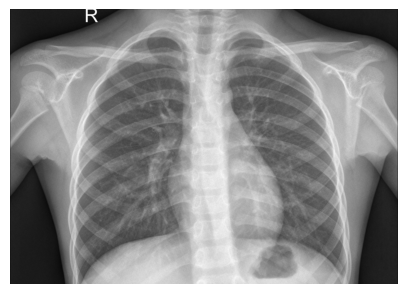

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import cv2

# Montar o Google Drive
#drive.mount('/content/drive')

# Caminho da imagem
#image_path = "/content/drive/MyDrive/chest_xray_pequeno/test/person1_virus_11.jpeg"
image_path = "/content/drive/MyDrive/chest_xray/test/NORMAL/IM-0001-0001.jpeg"

# Carregar a imagem em escala de cinza (opcional)
image = cv2.imread(image_path)  # Para RGB use cv2.IMREAD_COLOR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertendo para RGB

# Exibir a imagem
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')  # Remove os eixos
plt.show()


In [ ]:
TEST_DIR

'/content/drive/MyDrive/chest_xray/test'

In [ ]:
#Using keras ImageGenerator and flow_from_directoty

# Subdivision in test/validation

# Without data augmentation
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# If you want data augmentation, uncomment and run the following
## data_generator = ImageDataGenerator(
##         validation_split=0.2,
##         rotation_range=20,
##         width_shift_range=0.2,
##         height_shift_range=0.2,
##         rescale=1./255,
##         shear_range=0.2,
##         zoom_range=0.2,
##         horizontal_flip=True,
##         fill_mode='nearest')

val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [ ]:
data_generator

In [ ]:
val_data_generator

In [ ]:
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')

# Tamanho da imagem
im_shape = (250, 250)  # Ajuste conforme necess√°rio
BATCH_SIZE = 32
seed = 42

# Generator para parte train
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte valida√ß√£o
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

print(f"Total de imagens de treino: {nb_train_samples}")
print(f"Total de imagens de valida√ß√£o: {nb_validation_samples}")
print(f"Total de imagens de teste: {nb_test_samples}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']
Total de imagens de treino: 4187
Total de imagens de valida√ß√£o: 1045
Total de imagens de teste: 624


In [28]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')

# Definir os diret√≥rios
#TRAINING_DIR = "/content/drive/MyDrive/chest_xray/train"
#TEST_DIR = "/content/drive/MyDrive/chest_xray/test"

# Tamanho da imagem
im_shape = (250, 250)  # Ajuste conforme necess√°rio
BATCH_SIZE = 32
seed = 42

# Fun√ß√£o para pegar 10% dos arquivos em cada classe
def get_limited_data(directory, fraction=0.05):
    all_classes = os.listdir(directory)
    sampled_files = []

    for class_name in all_classes:
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            files = np.array(os.listdir(class_path))  # Lista os arquivos
            np.random.shuffle(files)  # Embaralha os arquivos
            sample_size = max(1, int(len(files) * fraction))  # Calcula 10% (m√≠nimo de 1)
            sampled_files.extend([(class_name, f) for f in files[:sample_size]])

    return sampled_files

# Criar gerador de imagens para treino e valida√ß√£o
train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 80% treino, 20% valida√ß√£o

train_generator = train_data_gen.flow_from_directory(
    TRAINING_DIR, target_size=im_shape, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True, seed=seed, subset="training")

validation_generator = train_data_gen.flow_from_directory(
    TRAINING_DIR, target_size=im_shape, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False, seed=seed, subset="validation")

# Criar gerador de imagens para teste com 10% dos arquivos
test_files = get_limited_data(TEST_DIR, fraction=0.05)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_DIR, target_size=im_shape, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False, seed=seed)

# Ajustar o n√∫mero de amostras
nb_train_samples = int(train_generator.samples * 0.05)
nb_validation_samples = int(validation_generator.samples * 0.05)
nb_test_samples = len(test_files)

classes = list(train_generator.class_indices.keys())
print('Classes:', classes)
num_classes = len(classes)

print(f"Total de imagens de treino: {nb_train_samples}")
print(f"Total de imagens de valida√ß√£o: {nb_validation_samples}")
print(f"Total de imagens de teste: {nb_test_samples}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']
Total de imagens de treino: 209
Total de imagens de valida√ß√£o: 52
Total de imagens de teste: 30


In [ ]:
train_generator

In [ ]:
test_generator

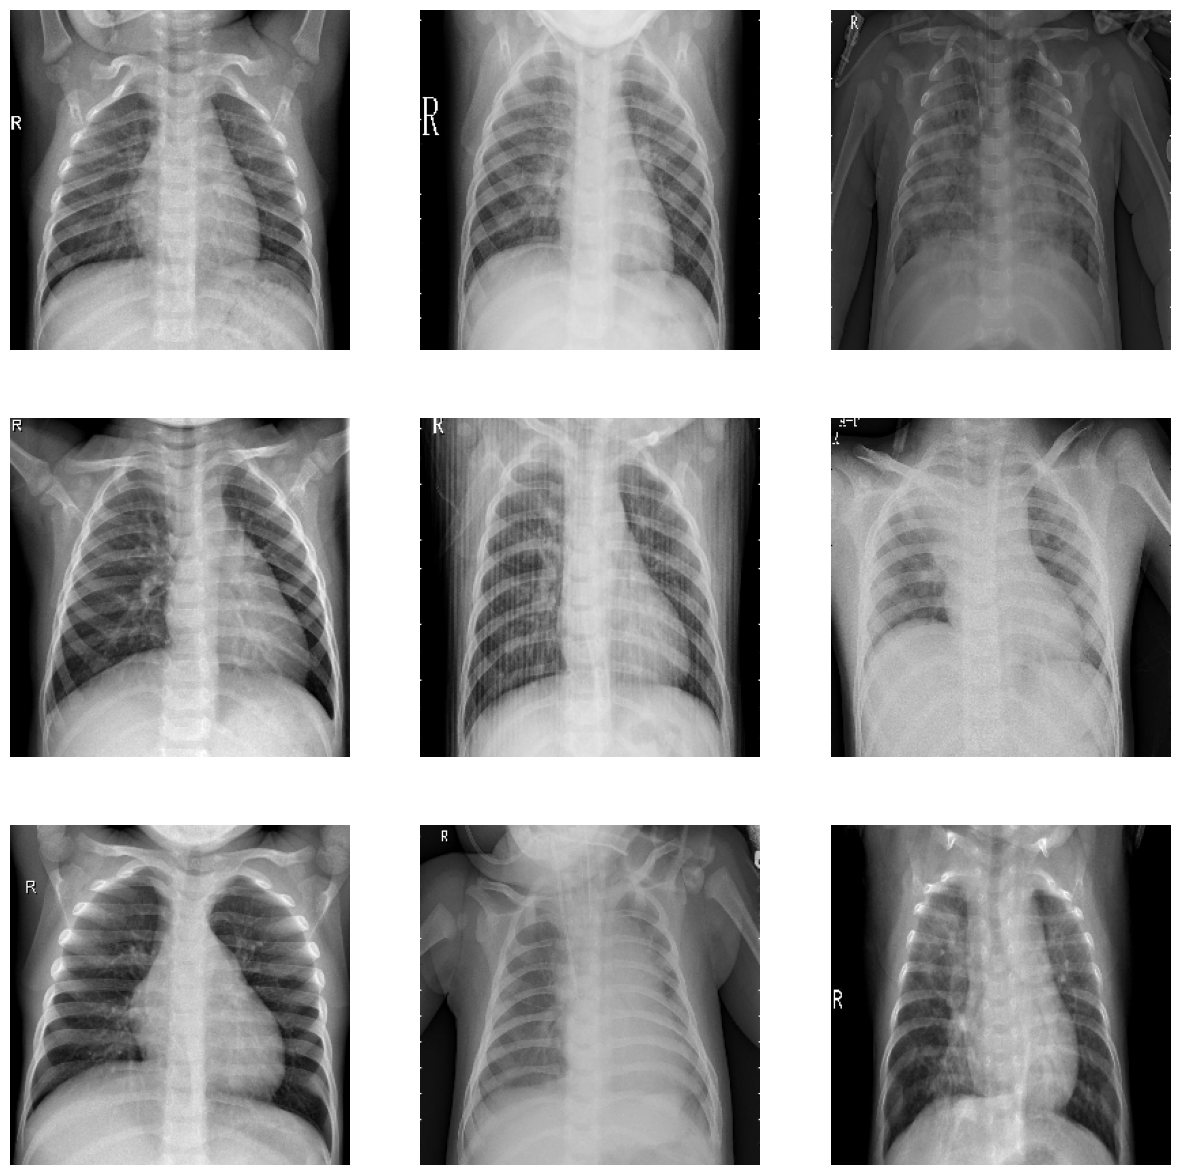

In [ ]:
import matplotlib.pyplot as plt

# Visualizando algumas imagens do gerador de treinamento
plt.figure(figsize=(15, 15))

for i in range(9):
    plt.subplot(330 + 1 + i)

    # Obt√©m um batch de imagens e seleciona a primeira imagem do lote
    batch = next(train_generator)[0] * 255
    image = batch[0].astype('uint8')  # Pegando apenas a primeira imagem do batch

    plt.imshow(image)
    plt.axis('off')  # Remove os eixos para melhor visualiza√ß√£o

plt.show()


# **Modelo keras.applications DenseNet121**


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Carregar o modelo pr√©-treinado sem a √∫ltima camada
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# Criar um novo modelo com camadas extras
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    #Dense(1, activation='sigmoid')  # Para classifica√ß√£o bin√°ria
    Dense(2, activation='softmax')  # Para classifica√ß√£o multiclasse
])

# Congelar as camadas pr√©-treinadas
for layer in base_model.layers:
    layer.trainable = False

# Compilar
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ densenet121 (Functional)        ‚îÇ (None, 7, 7, 1024)     ‚îÇ     7,037,504 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_2 (Flatten)             ‚îÇ (None, 50176)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                 ‚îÇ (None, 256)            ‚îÇ    12,845,312 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_5 (Dense)                 ‚îÇ (None, 2)              ‚îÇ           514 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 19,883,330 (75.85 MB)

 Trainable params: 12,845,826 (49.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
#epochs = 80 xxxx
epochs = 10


from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='modelvgg16.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]


# ‚úÖ **CORRE√á√ÉO**: Ajuste `class_mode="binary"` para corresponder √† sa√≠da do modelo
train_generator = data_generator.flow_from_directory(
    TRAINING_DIR,
    target_size=(250, 250),
    shuffle=True,
    seed=seed,
    class_mode='binary',  # <- Importante: Sa√≠da deve ser bin√°ria
    batch_size=BATCH_SIZE,
    subset="training"
)

validation_generator = val_data_generator.flow_from_directory(
    TRAINING_DIR,
    target_size=(250, 250),
    shuffle=False,
    seed=seed,
    class_mode='binary',  # <- Importante: Sa√≠da deve ser bin√°ria
    batch_size=BATCH_SIZE,
    subset="validation"
)

# üöÄ **Treinamento**
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // BATCH_SIZE,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator,
   validation_steps=nb_validation_samples // BATCH_SIZE,
    verbose=1
)


#Training
## history = model.fit(
##         train_generator,
##         steps_per_epoch=nb_train_samples // BATCH_SIZE,
##         epochs=epochs,
##         callbacks = callbacks_list,
##         validation_data=validation_generator,
##         verbose = 1,
##         validation_steps=nb_validation_samples // BATCH_SIZE)

#Desempenho nos dados de treino
#loss - Erro. Ideal √© chegar em 0
#accuracy - % de acerto. Ideal √© chegar em 100%

#Desempenho nos dados de valida√ß√£o
#val_loss
#val_accuracy

NameError: name 'data_generator' is not defined

In [ ]:
from tensorflow import keras

# Definindo o n√∫mero de √©pocas e o batch size
epochs = 10

# Callback para salvar o melhor modelo
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model_densenet121.h5',  # üîÑ Nome atualizado
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1
    )
]

# üöÄ Treinamento
history = model.fit(
    train_generator,  # Gerador de dados de treino
    steps_per_epoch=nb_train_samples // BATCH_SIZE,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // BATCH_SIZE,
    verbose=1
)


Epoch 1/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 22s/step - accuracy: 0.6797 - loss: 9.3402 
Epoch 1: val_loss improved from inf to 4.13865, saving model to model_densenet121.h5


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 247s 37s/step - accuracy: 0.6912 - loss: 9.2441 - val_accuracy: 0.8750 - val_loss: 4.1386
Epoch 2/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 22s/step - accuracy: 0.9384 - loss: 1.7946 
Epoch 2: val_loss improved from 4.13865 to 2.91676, saving model to model_densenet121.h5


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 133s 27s/step - accuracy: 0.9368 - loss: 1.7226 - val_accuracy: 0.8125 - val_loss: 2.9168
Epoch 3/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 21s/step - accuracy: 0.9642 - loss: 0.5713 
Epoch 3: val_loss improved from 2.91676 to 0.28435, saving model to model_densenet121.h5


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 107s 21s/step - accuracy: 0.9619 - loss: 0.6105 - val_accuracy: 0.9062 - val_loss: 0.2843
Epoch 4/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 25s/step - accuracy: 0.8964 - loss: 1.0233 
Epoch 4: val_loss did not improve from 0.28435
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 201s 36s/step - accuracy: 0.8978 - loss: 1.0552 - val_accuracy: 0.6562 - val_loss: 4.2276
Epoch 5/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15s/step - accuracy: 0.9722 - loss: 0.5831 
Epoch 5: val_loss improved from 0.28435 to 0.00227, saving model to model_densenet121.h5


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 80s 16s/step - accuracy: 0.9717 - loss: 0.5752 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 6/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 23s/step - accuracy: 0.9626 - loss: 0.2241 
Epoch 6: val_loss did not improve from 0.00227
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 139s 24s/step - accuracy: 0.9590 - loss: 0.2502 - val_accuracy: 0.9062 - val_loss: 0.3363
Epoch 7/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 18s/step - accuracy: 0.9589 - loss: 0.3707 
Epoch 7: val_loss did not improve from 0.00227
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 104s 18s/step - accuracy: 0.9595 - loss: 0.3546 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 8/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 19s/step - accuracy: 0.9559 - loss: 0.1921 
Epoch 8: val_loss did not improve from 0.00227
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

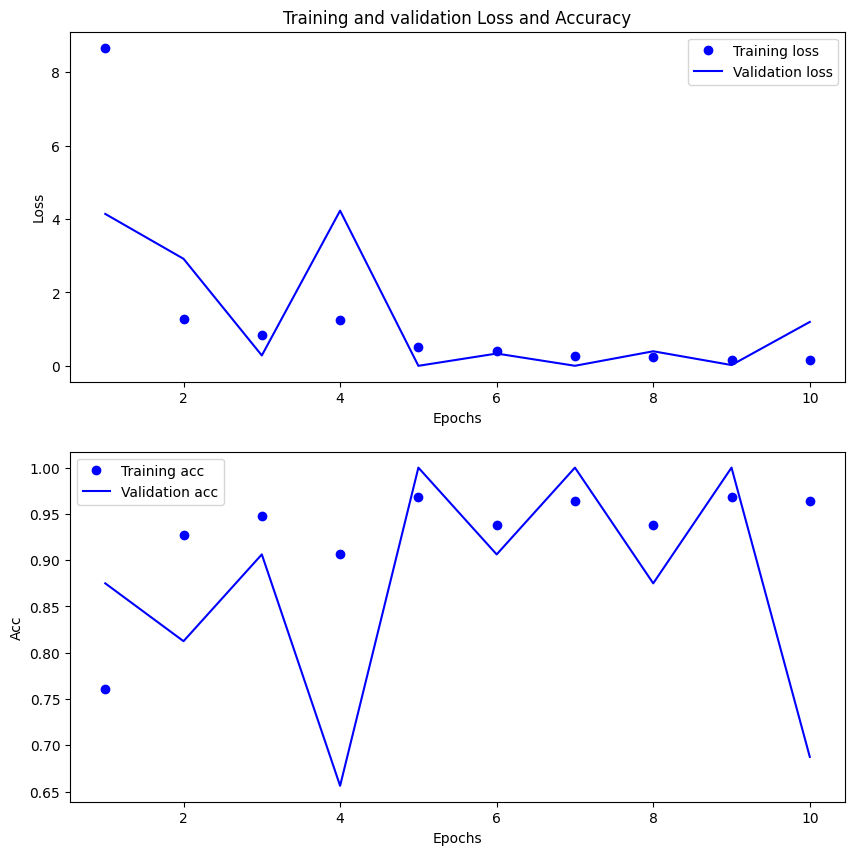

In [ ]:
# Training curves
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
# Load the best saved model
from tensorflow.keras.models import load_model

model = load_model('model_densenet121.h5')

In [ ]:
# ‚úÖ Avaliando com o dataset de valida√ß√£o
score = model.evaluate(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])


33/33 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 421ms/step - accuracy: 0.9453 - loss: 0.5208
Val loss: 0.8640068173408508
Val accuracy: 0.9090909361839294


In [ ]:
# ‚úÖ Avaliando com o dataset de teste
# Using the test dataset
### score = model.evaluate(test_generator)
### print('Test loss:', score[0])
### print('Test accuracy:', score[1])

# Generator para teste
# test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
#     TEST_DIR,
#     target_size=im_shape,
#     batch_size=BATCH_SIZE,
#     class_mode='binary',
#     shuffle=False,
#     seed=seed
# )


score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Defina o n√∫mero de amostras de teste e o tamanho do lote
# BATCH_SIZE = 16  # Ajuste conforme necess√°rio
# # nb_test_samples = test_generator.samples  # N√∫mero total de amostras no conjunto de teste
# # steps_test = nb_test_samples // BATCH_SIZE  # N√∫mero de steps para o teste

# Usando o dataset de teste
# score = model.evaluate(test_generator, steps=steps_test, verbose=1)

# Exibindo as m√©tricas
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])




ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 2)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Obter as previs√µes
predictions = model.predict(test_generator, verbose=1)

# Obter os r√≥tulos reais
true_labels = test_generator.classes

# Calcular a acur√°cia
accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))

print(f"Test Accuracy: {accuracy}")


20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 34s 1s/step
Test Accuracy: 0.8926282051282052


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# üîπ Previs√µes do modelo (probabilidades)
predictions = model.predict(test_generator, verbose=1)

# üîπ R√≥tulos reais (inteiros)
true_labels = test_generator.classes

# üîπ Calcular acur√°cia (usando classe com maior probabilidade)
accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))
print(f"Test Accuracy: {accuracy:.4f}")

# üîπ Calcular AUC
# Para 2 classes, usa-se multi_class='ovr'
auc = roc_auc_score(true_labels, predictions[:,1], multi_class='ovr')
print(f"Test AUC: {auc:.4f}")


20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 320ms/step
Test Accuracy: 0.8926
Test AUC: 0.9217


In [ ]:
import tensorflow as tf
print(tf.__version__)



2.19.0


In [ ]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 404ms/step
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


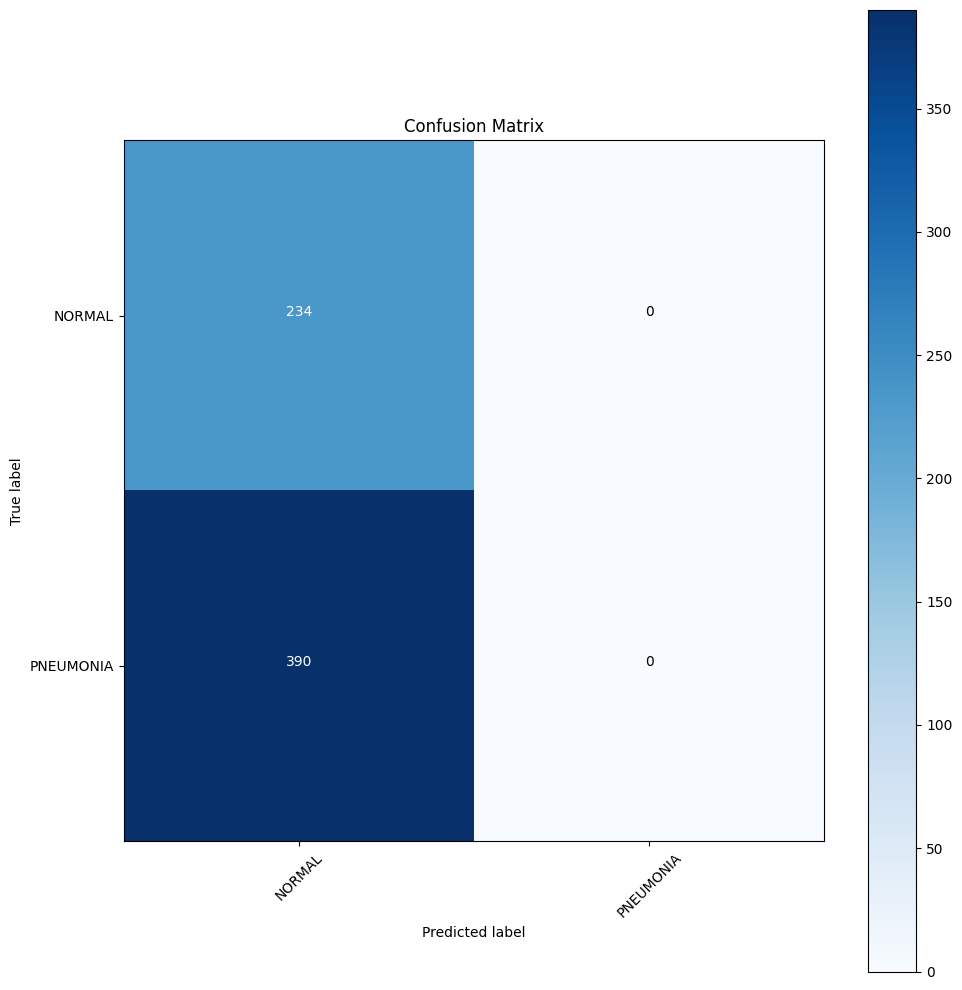

In [ ]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# On test dataset
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))


In [ ]:
print(model.input_shape)

(None, 250, 250, 3)


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 15s 15s/step


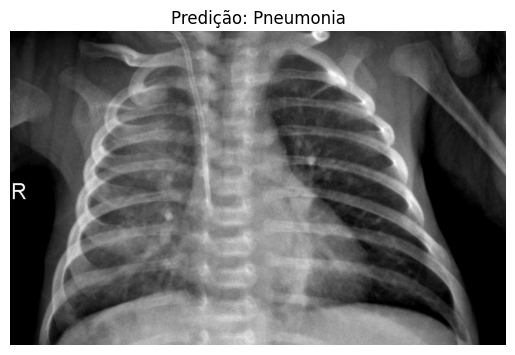

A imagem foi classificada como: Pneumonia


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Carrega o modelo treinado
model = load_model('model_densenet121.h5')

# Dicion√°rio de classes
class_dict = {0: "Normal", 1: "Pneumonia"}  # Ajuste conforme necess√°rio

def preprocess_image(img_path, target_size=(250, 250)):  # Alterado para 250x250
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normaliza√ß√£o
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona dimens√£o do batch
    return img_array

def predict_image(img_path):
    """Classifica a imagem carregada."""
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)  # Obt√©m o √≠ndice da classe com maior probabilidade
    class_label = class_dict[class_idx]  # Obt√©m o r√≥tulo da classe

    # Exibe a imagem e a previs√£o
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"Predi√ß√£o: {class_label}")
    plt.show()

    return class_label

# Exemplo de uso: carregue uma imagem do seu Colab e passe o caminho dela
img_path = "/content/drive/MyDrive/chest_xray_pequeno/train/NORMAL/person10_bacteria_43.jpeg"  # Substitua pelo caminho real
resultado = predict_image(img_path)
print("A imagem foi classificada como:", resultado)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 13s/step


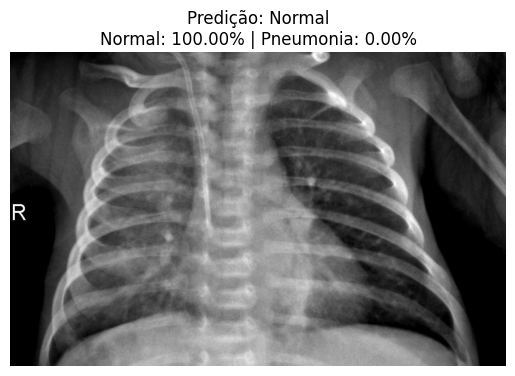

A imagem foi classificada como: Normal
Probabilidade de ser Normal: 100.00%
Probabilidade de ser Pneumonia: 0.00%


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Carrega o modelo treinado
model = load_model('model_densenet121.h5')

# Dicion√°rio de classes
class_dict = {0: "Normal", 1: "Pneumonia"}  # Ajuste conforme necess√°rio

def preprocess_image(img_path, target_size=(250, 250)):
    """Carrega e processa a imagem para o modelo."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normaliza a imagem
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona dimens√£o do batch
    return img_array

def predict_image(img_path):
    """Classifica a imagem carregada e exibe as probabilidades."""
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)[0]  # Obt√©m o valor da probabilidade (vetor de 1x1 para bin√°rio)

    # A probabilidade de ser Pneumonia (valores entre 0 e 1)
    prob_pneumonia = prediction[0] * 100  # Convertendo para porcentagem
    prob_normal = 100 - prob_pneumonia  # Como √© bin√°rio, a probabilidade de normal √© o complemento

    # √çndice e nome da classe com maior probabilidade
    class_idx = 1 if prob_pneumonia > 50 else 0  # Se a probabilidade for maior que 50% √© Pneumonia
    class_label = class_dict[class_idx]

    # Exibe a imagem e as probabilidades
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"Predi√ß√£o: {class_label}\nNormal: {prob_normal:.2f}% | Pneumonia: {prob_pneumonia:.2f}%")
    plt.show()

    return class_label, prob_normal, prob_pneumonia

# Exemplo de uso
img_path = "/content/drive/MyDrive/chest_xray_pequeno/train/NORMAL/person10_bacteria_43.jpeg"  # Substitua pelo caminho real
resultado, prob_normal, prob_pneumonia = predict_image(img_path)

# Exibe as probabilidades no console
print(f"A imagem foi classificada como: {resultado}")
print(f"Probabilidade de ser Normal: {prob_normal:.2f}%")
print(f"Probabilidade de ser Pneumonia: {prob_pneumonia:.2f}%")



1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 13s/step


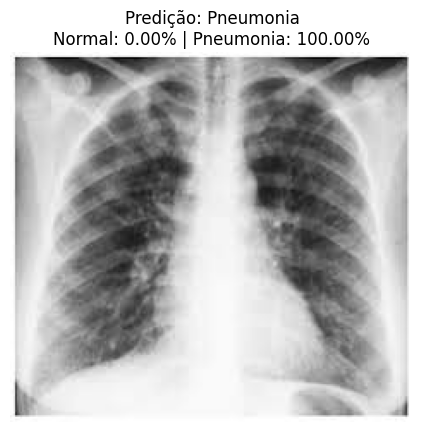

A imagem foi classificada como: Pneumonia
Probabilidade de ser Normal: 0.00%
Probabilidade de ser Pneumonia: 100.00%


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Carrega o modelo treinado
model = load_model('model_densenet121.h5')

# Dicion√°rio de classes
class_dict = {0: "Normal", 1: "Pneumonia"}  # Ajuste conforme necess√°rio

def preprocess_image(img_path, target_size=(250, 250)):
    """Carrega e processa a imagem para o modelo."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normaliza a imagem
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona dimens√£o do batch
    return img_array

def predict_image(img_path):
    """Classifica a imagem carregada e exibe as probabilidades."""
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)[0]  # Obt√©m os valores de sa√≠da da rede

    # Probabilidades das classes
    prob_normal = prediction[0] * 100  # Convertendo para porcentagem
    prob_pneumonia = prediction[1] * 100  # Convertendo para porcentagem

    # √çndice e nome da classe com maior probabilidade
    class_idx = np.argmax(prediction)
    class_label = class_dict[class_idx]

    # Exibe a imagem e as probabilidades
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"Predi√ß√£o: {class_label}\nNormal: {prob_normal:.2f}% | Pneumonia: {prob_pneumonia:.2f}%")
    plt.show()

    return class_label, prob_normal, prob_pneumonia

# Exemplo de uso
img_path = "/content/drive/MyDrive/images/pulmao.jpeg"  # Substitua pelo caminho real
resultado, prob_normal, prob_pneumonia = predict_image(img_path)

# Exibe as probabilidades no console
print(f"A imagem foi classificada como: {resultado}")
print(f"Probabilidade de ser Normal: {prob_normal:.2f}%")
print(f"Probabilidade de ser Pneumonia: {prob_pneumonia:.2f}%")

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 12s/step


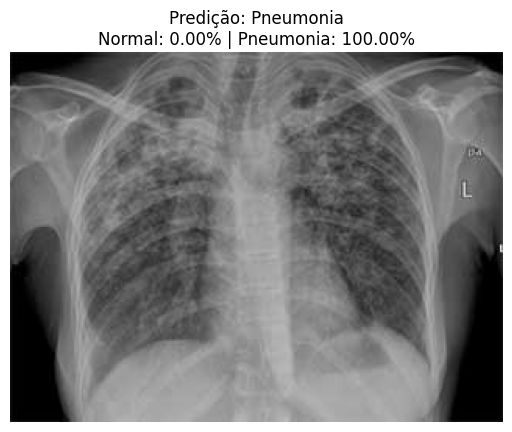

A imagem foi classificada como: Pneumonia
Probabilidade de ser Normal: 0.00%
Probabilidade de ser Pneumonia: 100.00%


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Carrega o modelo treinado
model = load_model('model_densenet121.h5')

# Dicion√°rio de classes
class_dict = {0: "Normal", 1: "Pneumonia"}  # Ajuste conforme necess√°rio

def preprocess_image(img_path, target_size=(250, 250)):
    """Carrega e processa a imagem para o modelo."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normaliza a imagem
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona dimens√£o do batch
    return img_array

def predict_image(img_path):
    """Classifica a imagem carregada e exibe as probabilidades."""
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)[0]  # Obt√©m os valores de sa√≠da da rede

    # Probabilidades das classes
    prob_normal = prediction[0] * 100  # Convertendo para porcentagem
    prob_pneumonia = prediction[1] * 100  # Convertendo para porcentagem

    # √çndice e nome da classe com maior probabilidade
    class_idx = np.argmax(prediction)
    class_label = class_dict[class_idx]

    # Exibe a imagem e as probabilidades
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"Predi√ß√£o: {class_label}\nNormal: {prob_normal:.2f}% | Pneumonia: {prob_pneumonia:.2f}%")
    plt.show()

    return class_label, prob_normal, prob_pneumonia

# Exemplo de uso
img_path = "/content/drive/MyDrive/images/pneumonia-bilateral.jpg"  # Substitua pelo caminho real
resultado, prob_normal, prob_pneumonia = predict_image(img_path)

# Exibe as probabilidades no console
print(f"A imagem foi classificada como: {resultado}")
print(f"Probabilidade de ser Normal: {prob_normal:.2f}%")
print(f"Probabilidade de ser Pneumonia: {prob_pneumonia:.2f}%")

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Carrega o modelo treinado
model = load_model('model_densenet121.h5')

# Dicion√°rio de classes
class_dict = {0: "Normal", 1: "Pneumonia"}  # Ajuste conforme necess√°rio

def preprocess_image(img_path, target_size=(250, 250)):
    """Carrega e processa a imagem para o modelo."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normaliza a imagem
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona dimens√£o do batch
    return img_array

def predict_image(img_path):
    """Classifica a imagem carregada e exibe as probabilidades."""
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)[0]  # Obt√©m os valores de sa√≠da da rede

    # Probabilidades das classes
    prob_normal = prediction[0] * 100  # Convertendo para porcentagem
    prob_pneumonia = prediction[1] * 100  # Convertendo para porcentagem

    # √çndice e nome da classe com maior probabilidade
    class_idx = np.argmax(prediction)
    class_label = class_dict[class_idx]

    # Exibe a imagem e as probabilidades
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"Predi√ß√£o: {class_label}\nNormal: {prob_normal:.2f}% | Pneumonia: {prob_pneumonia:.2f}%")
    plt.show()

    return class_label, prob_normal, prob_pneumonia

# Exemplo de uso
img_path = "/content/drive/MyDrive/images/abcesso-pulmonar.jpg"  # Substitua pelo caminho real
resultado, prob_normal, prob_pneumonia = predict_image(img_path)

# Exibe as probabilidades no console
print(f"A imagem foi classificada como: {resultado}")
print(f"Probabilidade de ser Normal: {prob_normal:.2f}%")
print(f"Probabilidade de ser Pneumonia: {prob_pneumonia:.2f}%")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'model_densenet121.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

29084464/29084464 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step


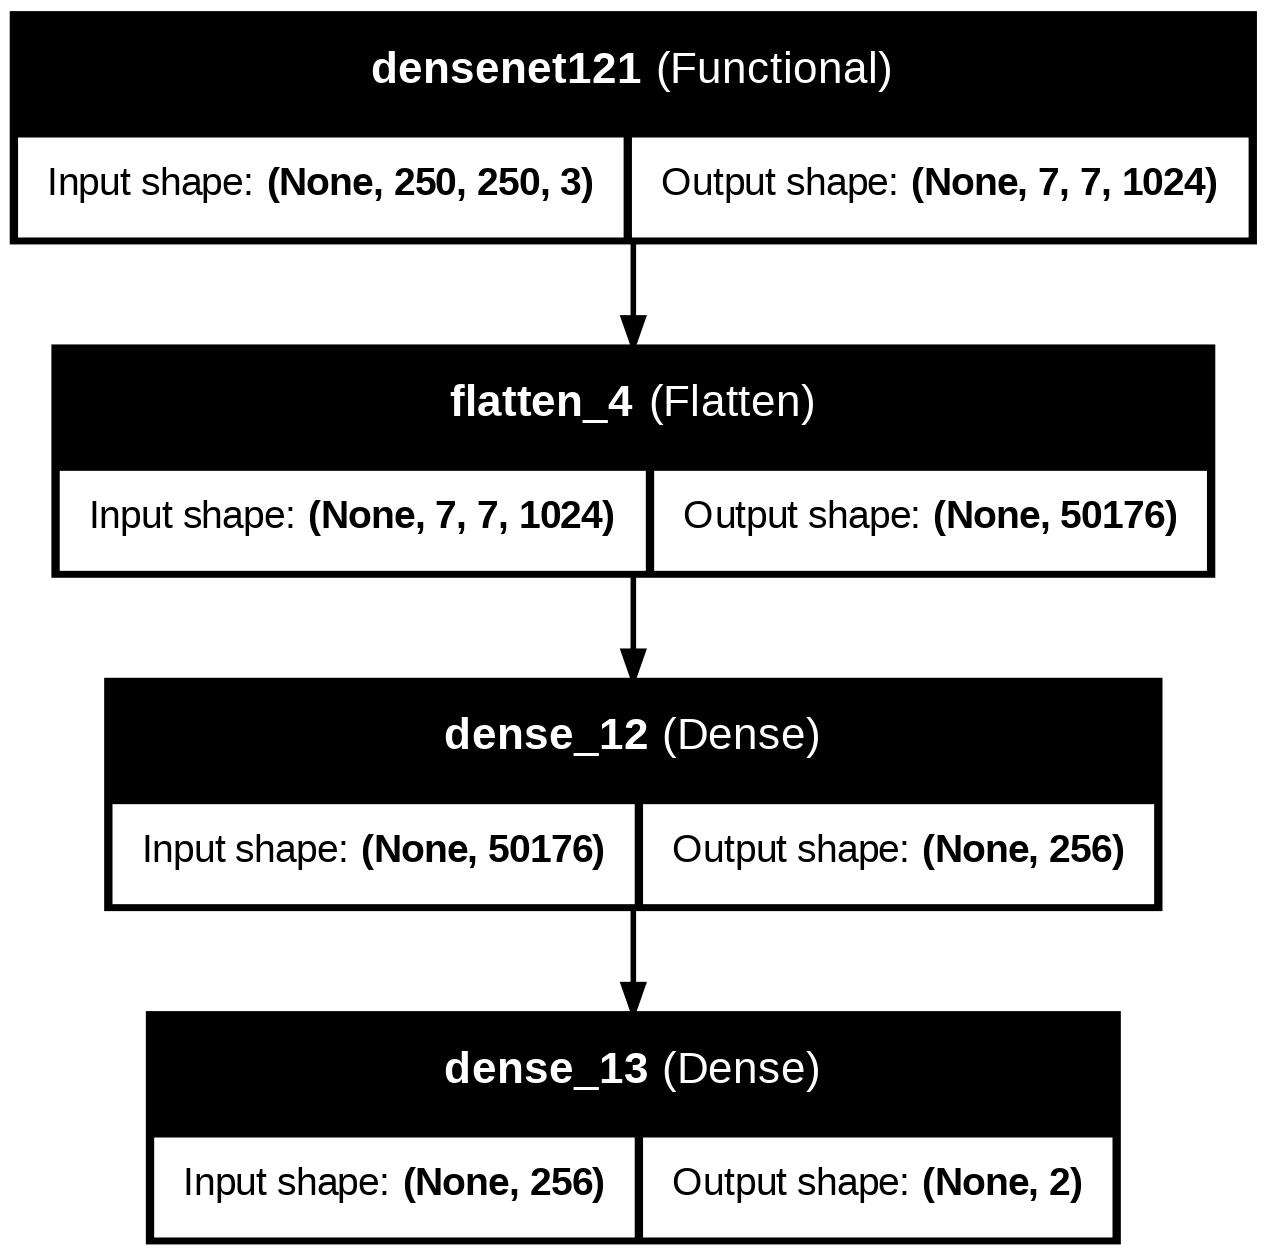

In [35]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# üîπ Defini√ß√£o do modelo DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')  # üîÑ 2 classes
])

# üîπ Plotar o modelo e salvar como imagem
plot_model(model, to_file='densenet121_model.png', show_shapes=True, show_layer_names=True)

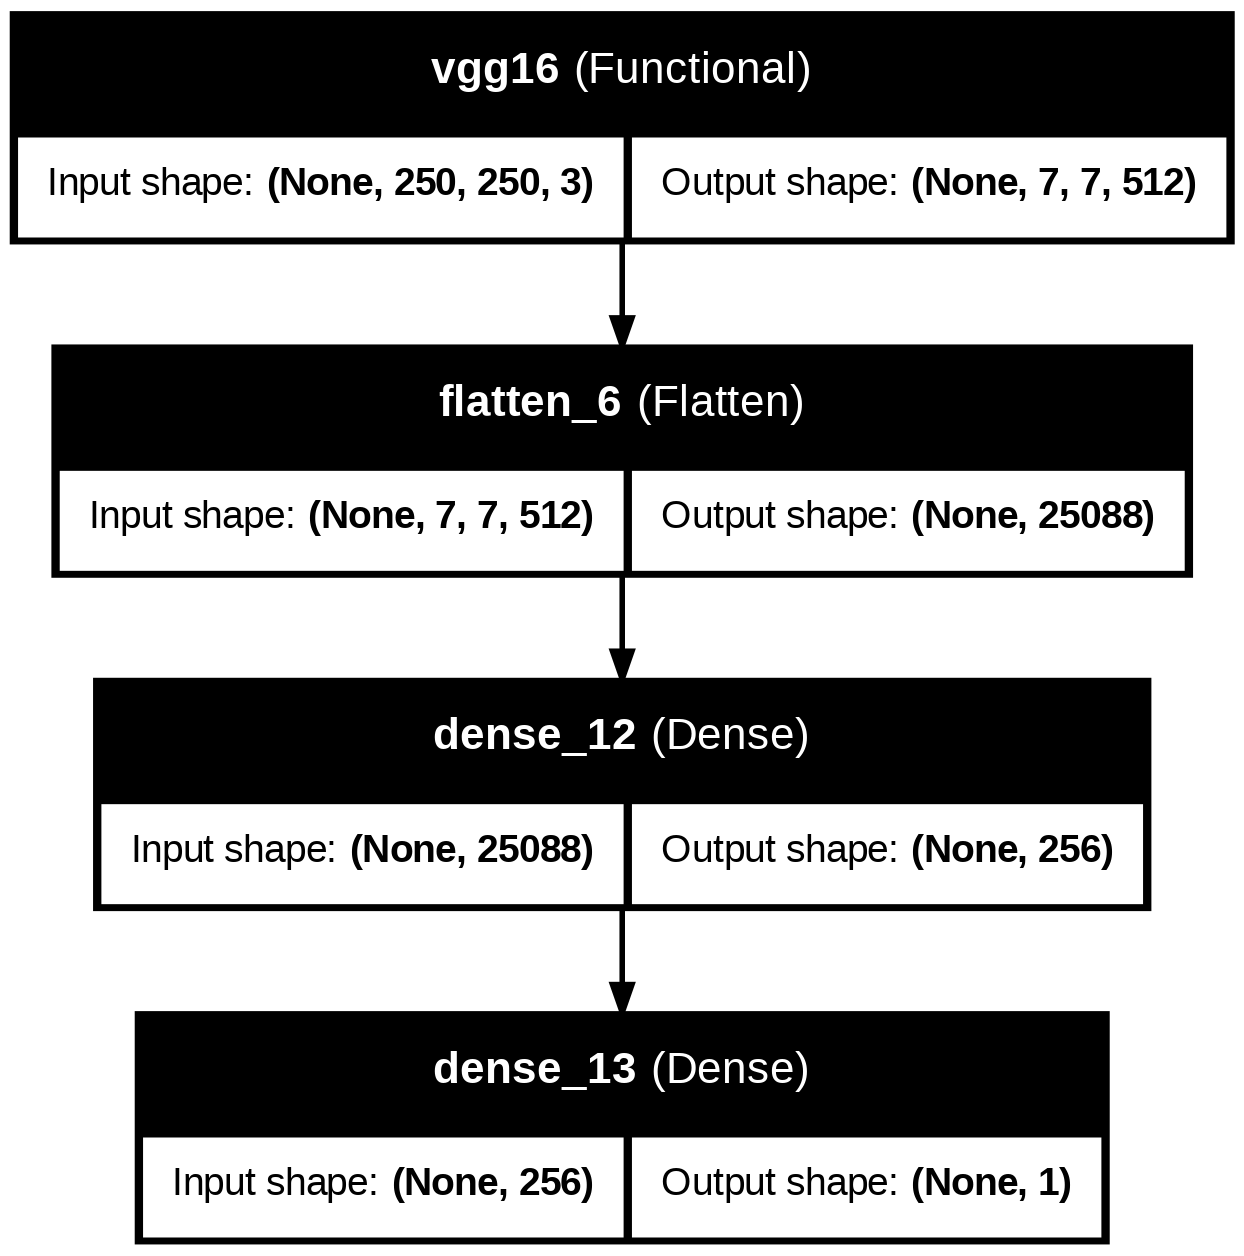

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='vgg16_model.png', show_shapes=True, show_layer_names=True)


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 610ms/step


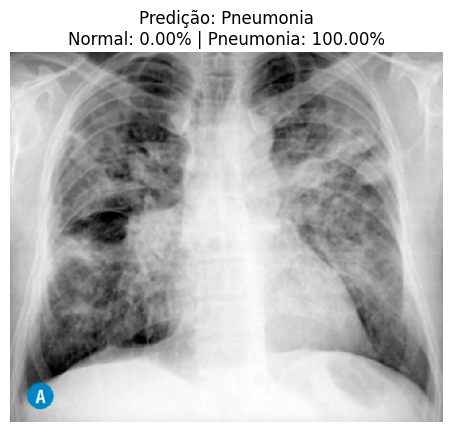

A imagem foi classificada como: Pneumonia
Probabilidade de ser Normal: 0.00%
Probabilidade de ser Pneumonia: 100.00%


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Carrega o modelo treinado
model = load_model('modelvgg16.h5')

# Dicion√°rio de classes
class_dict = {0: "Normal", 1: "Pneumonia"}  # Ajuste conforme necess√°rio

def preprocess_image(img_path, target_size=(250, 250)):
    """Carrega e processa a imagem para o modelo."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normaliza a imagem
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona dimens√£o do batch
    return img_array

def predict_image(img_path):
    """Classifica a imagem carregada e exibe as probabilidades."""
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)[0]  # Obt√©m os valores de sa√≠da da rede

    # Probabilidades das classes
    prob_normal = prediction[0] * 100  # Convertendo para porcentagem
    prob_pneumonia = prediction[1] * 100  # Convertendo para porcentagem

    # √çndice e nome da classe com maior probabilidade
    class_idx = np.argmax(prediction)
    class_label = class_dict[class_idx]

    # Exibe a imagem e as probabilidades
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"Predi√ß√£o: {class_label}\nNormal: {prob_normal:.2f}% | Pneumonia: {prob_pneumonia:.2f}%")
    plt.show()

    return class_label, prob_normal, prob_pneumonia

# Exemplo de uso
img_path = "/content/drive/MyDrive/images/b9dc356e-pneumonia-3.jpg"  # Substitua pelo caminho real
resultado, prob_normal, prob_pneumonia = predict_image(img_path)

# Exibe as probabilidades no console
print(f"A imagem foi classificada como: {resultado}")
print(f"Probabilidade de ser Normal: {prob_normal:.2f}%")
print(f"Probabilidade de ser Pneumonia: {prob_pneumonia:.2f}%")

# **Modelo keras.applications DenseNet201**

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Carregar o modelo pr√©-treinado sem a √∫ltima camada
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# Criar um novo modelo com camadas extras
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')  # üîÑ Multiclasse
])

# Congelar as camadas pr√©-treinadas
for layer in base_model.layers:
    layer.trainable = False

# Compilar para classifica√ß√£o multiclasse
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()


74836368/74836368 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 0us/step


Model: "sequential_3"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ densenet201 (Functional)        ‚îÇ (None, 7, 7, 1920)     ‚îÇ    18,321,984 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_3 (Flatten)             ‚îÇ (None, 94080)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_6 (Dense)                 ‚îÇ (None, 256)            ‚îÇ    24,084,736 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_7 (Dense)                 ‚îÇ (None, 2)              ‚îÇ           514 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 42,407,234 (161.77 MB)

 Trainable params: 24,085,250 (91.88 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [ ]:
from tensorflow import keras

# Definindo o n√∫mero de √©pocas e o batch size
epochs = 10

# Callback para salvar o melhor modelo
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model_densenet201.h5',  # üîÑ Nome atualizado
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1
    )
]

# üöÄ Treinamento
history = model.fit(
    train_generator,  # Gerador de dados de treino
    steps_per_epoch=nb_train_samples // BATCH_SIZE,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // BATCH_SIZE,
    verbose=1
)


Epoch 1/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14s/step - accuracy: 0.4910 - loss: 26.4384 
Epoch 1: val_loss improved from inf to 0.00000, saving model to model_densenet201.h5


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 161s 20s/step - accuracy: 0.5086 - loss: 25.6638 - val_accuracy: 1.0000 - val_loss: 4.0978e-08
Epoch 2/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10s/step - accuracy: 0.8919 - loss: 0.8802
Epoch 2: val_loss did not improve from 0.00000
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 51s 10s/step - accuracy: 0.8925 - loss: 0.8861 - val_accuracy: 0.6250 - val_loss: 3.7022
Epoch 3/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 16s/step - accuracy: 0.9289 - loss: 0.6064 
Epoch 3: val_loss did not improve from 0.00000
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 95s 16s/step - accuracy: 0.9307 - loss: 0.5879 - val_accuracy: 1.0000 - val_loss: 0.0176
Epoch 4/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 14s/step - accuracy: 0.9043 - loss: 1.0073 
Epoch 4: val_loss did not improve from 0.00000
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

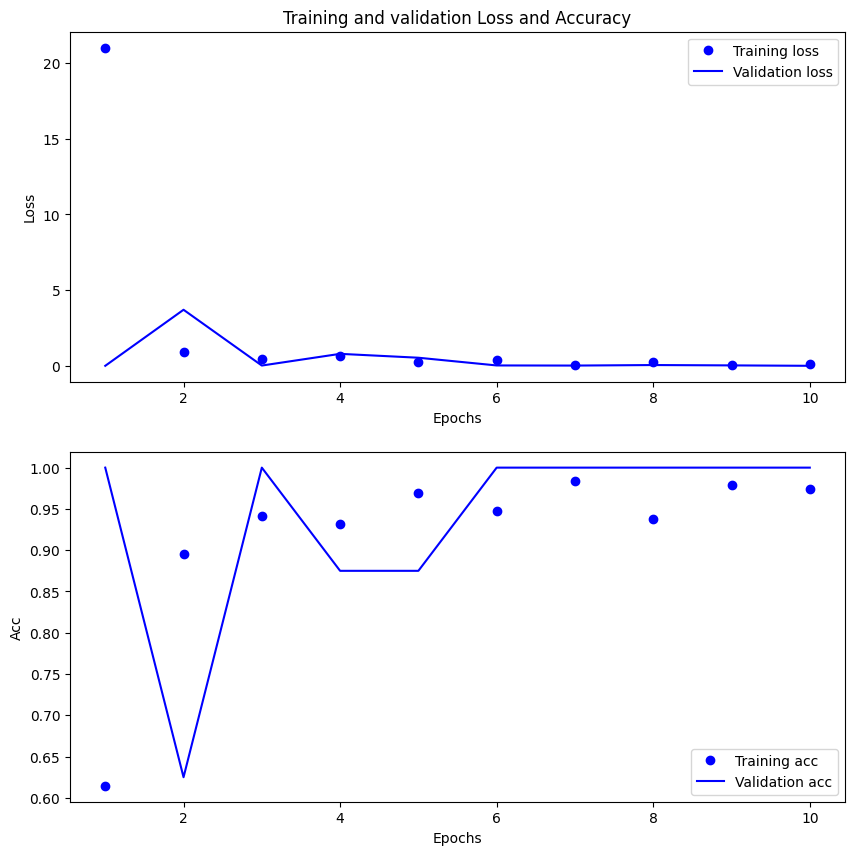

In [ ]:
# Training curves
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
# Load the best saved model
from tensorflow.keras.models import load_model

model = load_model('model_densenet201.h5')

In [ ]:
# ‚úÖ Avaliando com o dataset de valida√ß√£o
score = model.evaluate(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

33/33 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 68s 1s/step - accuracy: 0.8686 - loss: 1.6158
Val loss: 2.8502197265625
Val accuracy: 0.760765552520752


In [ ]:
# ‚úÖ Avaliando com o dataset de teste

score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



ValueError: Cannot take the length of shape with unknown rank.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# üîπ Previs√µes do modelo (probabilidades)
predictions = model.predict(test_generator, verbose=1)

# üîπ R√≥tulos reais (inteiros)
true_labels = test_generator.classes

# üîπ Calcular acur√°cia (usando classe com maior probabilidade)
accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))
print(f"Test Accuracy: {accuracy:.4f}")

# üîπ Calcular AUC
# Para 2 classes, usa-se multi_class='ovr'
auc = roc_auc_score(true_labels, predictions[:,1], multi_class='ovr')
print(f"Test AUC: {auc:.4f}")

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 63s 2s/step
Test Accuracy: 0.8221
Test AUC: 0.9183


In [ ]:
# Criar gerador de teste corretamente
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(250, 250),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # compat√≠vel com softmax
    shuffle=False               # importante para avalia√ß√£o
)

# Avaliar o modelo
score = model.evaluate(
    test_generator,
    steps=math.ceil(nb_test_samples / BATCH_SIZE),  # garante que todas as imagens sejam avaliadas
    verbose=1
)
print(f'Test Loss: {score[0]:.4f}, Test Accuracy: {score[1]:.4f}')


score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Found 624 images belonging to 2 classes.
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step - accuracy: 0.8125 - loss: 0.7170
Test Loss: 0.7170, Test Accuracy: 0.8125
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 26s 1s/step - accuracy: 0.8600 - loss: 1.1193
Test loss: 1.7176204919815063
Test accuracy: 0.8221153616905212


20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 56s 1s/step
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.71      0.90      0.79       234
   PNEUMONIA       0.93      0.77      0.84       390

    accuracy                           0.82       624
   macro avg       0.82      0.84      0.82       624
weighted avg       0.85      0.82      0.82       624



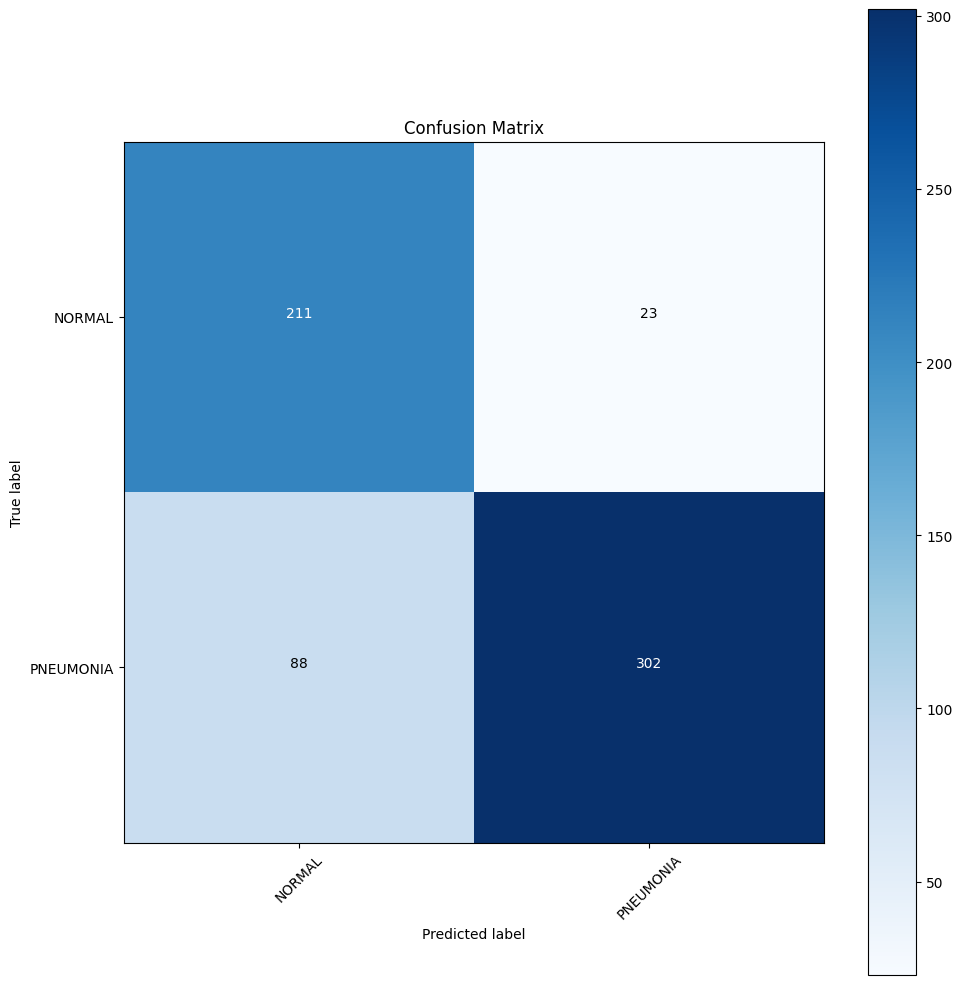

In [ ]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# On test dataset
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

# Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# **Modelo keras.applications ResNet50**

In [5]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# üîπ Carregar o modelo pr√©-treinado sem a √∫ltima camada
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# üîπ Criar um novo modelo com camadas extras
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')  # üîÑ Multiclasse
])

# üîπ Congelar as camadas pr√©-treinadas
for layer in base_model.layers:
    layer.trainable = False

# üîπ Compilar para classifica√ß√£o multiclasse
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# üîπ Resumo do modelo
model.summary()


Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ resnet50 (Functional)           ‚îÇ (None, 8, 8, 2048)     ‚îÇ    23,587,712 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_1 (Flatten)             ‚îÇ (None, 131072)         ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 256)            ‚îÇ    33,554,688 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                 ‚îÇ (None, 2)              ‚îÇ           514 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 57,142,914 (217.98 MB)

 Trainable params: 33,555,202 (128.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow import keras

# üîπ Defini√ß√£o do modelo ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')  # üîÑ 2 classes com softmax
])

# üîπ Congelar camadas pr√©-treinadas
for layer in base_model.layers:
    layer.trainable = False

# üîπ Compilar
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# üîπ Definindo o n√∫mero de √©pocas e o batch size
epochs = 10

# üîπ Callback para salvar o melhor modelo
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model_resnet50.h5',  # ‚úÖ Nome atualizado
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1
    )
]

# üöÄ Treinamento
history = model.fit(
    train_generator,  # Gerador de dados de treino
    steps_per_epoch=nb_train_samples // BATCH_SIZE,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // BATCH_SIZE,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11s/step - accuracy: 0.6839 - loss: 12.8154 
Epoch 1: val_loss improved from inf to 36.28092, saving model to model_resnet50.h5


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 98s 14s/step - accuracy: 0.6733 - loss: 12.8717 - val_accuracy: 0.0000e+00 - val_loss: 36.2809
Epoch 2/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9s/step - accuracy: 0.7111 - loss: 10.5107
Epoch 2: val_loss improved from 36.28092 to 0.00000, saving model to model_resnet50.h5


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 83s 15s/step - accuracy: 0.7144 - loss: 10.1543 - val_accuracy: 1.0000 - val_loss: 1.2666e-06
Epoch 3/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9s/step - accuracy: 0.4706 - loss: 5.8617
Epoch 3: val_loss did not improve from 0.00000
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 78s 14s/step - accuracy: 0.4911 - loss: 5.7146 - val_accuracy: 0.0000e+00 - val_loss: 25.0178
Epoch 4/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9s/step - accuracy: 0.6826 - loss: 5.0091
Epoch 4: val_loss did not improve from 0.00000
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 63s 11s/step - accuracy: 0.6691 - loss: 4.8393 - val_accuracy: 0.0000e+00 - val_loss: 3.9371
Epoch 5/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10s/step - accuracy: 0.7359 - loss: 2.0105
Epoch 5: val_loss did not improve from 0.00000
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

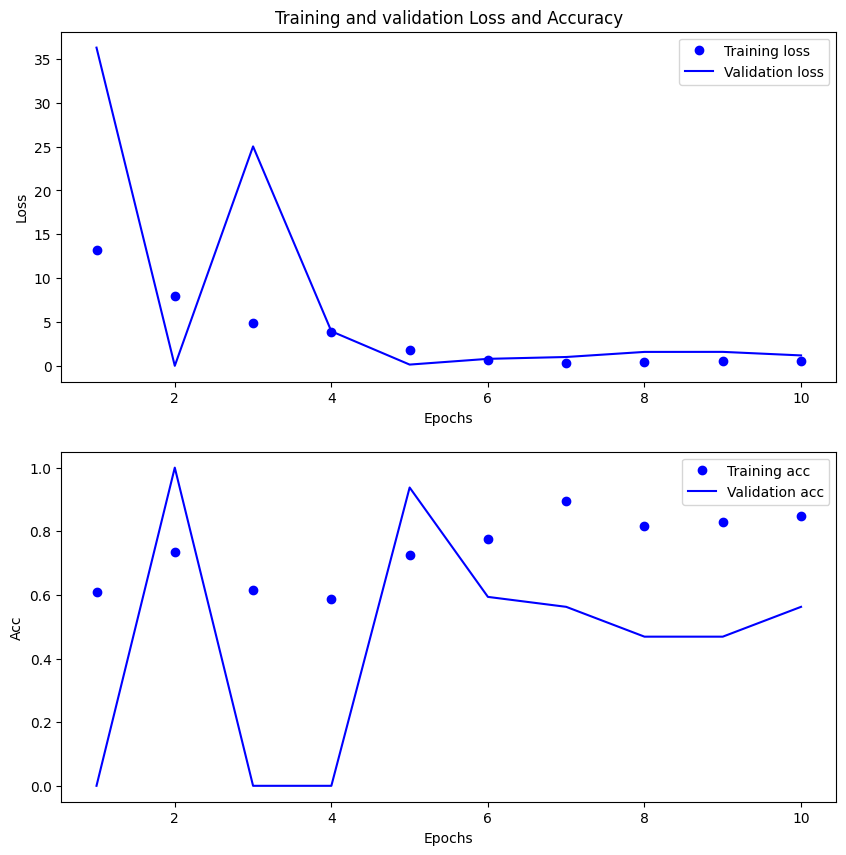

In [7]:
# Training curves
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [16]:
# Load the best saved model
from tensorflow.keras.models import load_model

model = load_model('model_resnet50.h5')

In [17]:
# ‚úÖ Avaliando com o dataset de valida√ß√£o
score = model.evaluate(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

33/33 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 275s 8s/step - accuracy: 0.5819 - loss: 4.9718
Val loss: 8.896903991699219
Val accuracy: 0.2574162781238556


In [18]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# üîπ Previs√µes do modelo (probabilidades)
predictions = model.predict(test_generator, verbose=1)

# üîπ R√≥tulos reais (inteiros)
true_labels = test_generator.classes

# üîπ Calcular acur√°cia (usando classe com maior probabilidade)
accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))
print(f"Test Accuracy: {accuracy:.4f}")

# üîπ Calcular AUC
# Para 2 classes, usa-se multi_class='ovr'
auc = roc_auc_score(true_labels, predictions[:,1], multi_class='ovr')
print(f"Test AUC: {auc:.4f}")


20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 160s 8s/step
Test Accuracy: 0.3750
Test AUC: 0.8449


20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 164s 8s/step


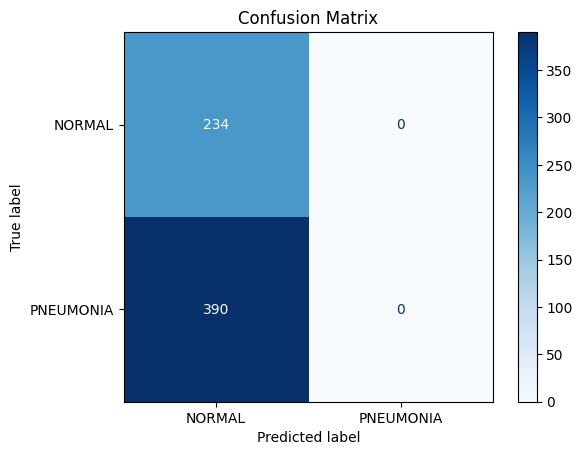

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
# Relat√≥rios
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Previs√µes
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Nomes das classes (pegando direto do generator)
target_names = list(test_generator.class_indices.keys())

# Matriz de confus√£o
cm = confusion_matrix(test_generator.classes, y_pred)

# Plot da matriz de confus√£o
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report")
print(classification_report(test_generator.classes, y_pred, target_names=target_names))


In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1) Gerar previs√µes no conjunto de teste
# Se voc√™ j√° tiver y_pred pronto, pode pular esta parte
Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)  # classes previstas

# 2) Distribui√ß√£o das previs√µes
unique, counts = np.unique(y_pred, return_counts=True)
print("Distribui√ß√£o de previs√µes:", dict(zip(unique, counts)))

# 3) Relat√≥rio de classifica√ß√£o (sem warnings)
print(classification_report(
    test_generator.classes,   # classes verdadeiras
    y_pred,                   # classes previstas
    target_names=list(test_generator.class_indices.keys()),
    zero_division=0           # evita warnings, coloca 0.0 onde n√£o h√° previs√£o
))

# 4) (Opcional) Matriz de confus√£o
cm = confusion_matrix(test_generator.classes, y_pred)
print("Matriz de confus√£o:\n", cm)


20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 161s 8s/step
Distribui√ß√£o de previs√µes: {np.int64(0): np.int64(624)}
              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624

Matriz de confus√£o:
 [[234   0]
 [390   0]]


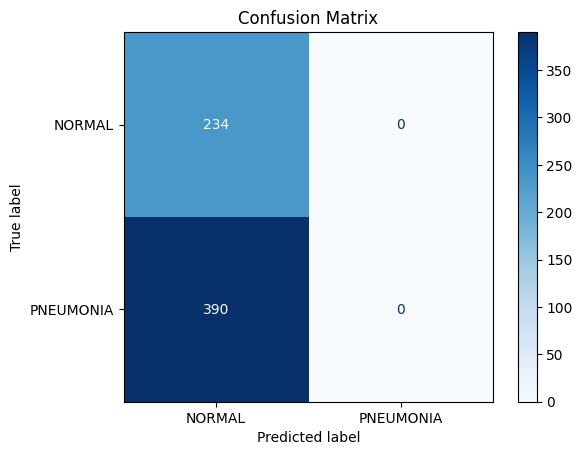

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
# Plot da matriz de confus√£o
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report")
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

# **Modelo keras.applications ResNet50**

In [19]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# üîπ Carregar o modelo pr√©-treinado sem a √∫ltima camada
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# üîπ Criar um novo modelo com camadas extras
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # üîÑ substitui Flatten() (mais eficiente para EfficientNet)
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')  # üîÑ Multiclasse
])

# üîπ Congelar as camadas pr√©-treinadas
for layer in base_model.layers:
    layer.trainable = False

# üîπ Compilar para classifica√ß√£o multiclasse
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# üîπ Resumo do modelo
model.summary()


16705208/16705208 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step


Model: "sequential_3"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ efficientnetb0 (Functional)     ‚îÇ (None, 8, 8, 1280)     ‚îÇ     4,049,571 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d        ‚îÇ (None, 1280)           ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_6 (Dense)                 ‚îÇ (None, 256)            ‚îÇ       327,936 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_7 (Dense)                 ‚îÇ (None, 2)              ‚îÇ           514 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [20]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow import keras

# üîπ Defini√ß√£o do modelo EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')  # üîÑ 2 classes com softmax
])

# üîπ Congelar camadas pr√©-treinadas
for layer in base_model.layers:
    layer.trainable = False

# üîπ Compilar
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# üîπ Definindo o n√∫mero de √©pocas e o batch size
epochs = 10

# üîπ Callback para salvar o melhor modelo
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model_efficientnetb0.h5',  # ‚úÖ Nome atualizado
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1
    )
]

# üöÄ Treinamento
history = model.fit(
    train_generator,  # Gerador de dados de treino
    steps_per_epoch=nb_train_samples // BATCH_SIZE,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // BATCH_SIZE,
    verbose=1
)


Epoch 1/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 6s/step - accuracy: 0.5670 - loss: 19.9997
Epoch 1: val_loss improved from inf to 0.00001, saving model to model_efficientnetb0.h5


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 63s 8s/step - accuracy: 0.5813 - loss: 20.0738 - val_accuracy: 1.0000 - val_loss: 6.1914e-06
Epoch 2/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4s/step - accuracy: 0.2694 - loss: 6.7647
Epoch 2: val_loss did not improve from 0.00001
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 31s 5s/step - accuracy: 0.2778 - loss: 6.4562 - val_accuracy: 0.0000e+00 - val_loss: 6.1163
Epoch 3/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 5s/step - accuracy: 0.7114 - loss: 2.0394
Epoch 3: val_loss did not improve from 0.00001
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 33s 6s/step - accuracy: 0.7132 - loss: 2.0145 - val_accuracy: 0.0000e+00 - val_loss: 2.5356
Epoch 4/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 5s/step - accuracy: 0.6563 - loss: 0.7115
Epoch 4: val_loss did not improve from 0.00001
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

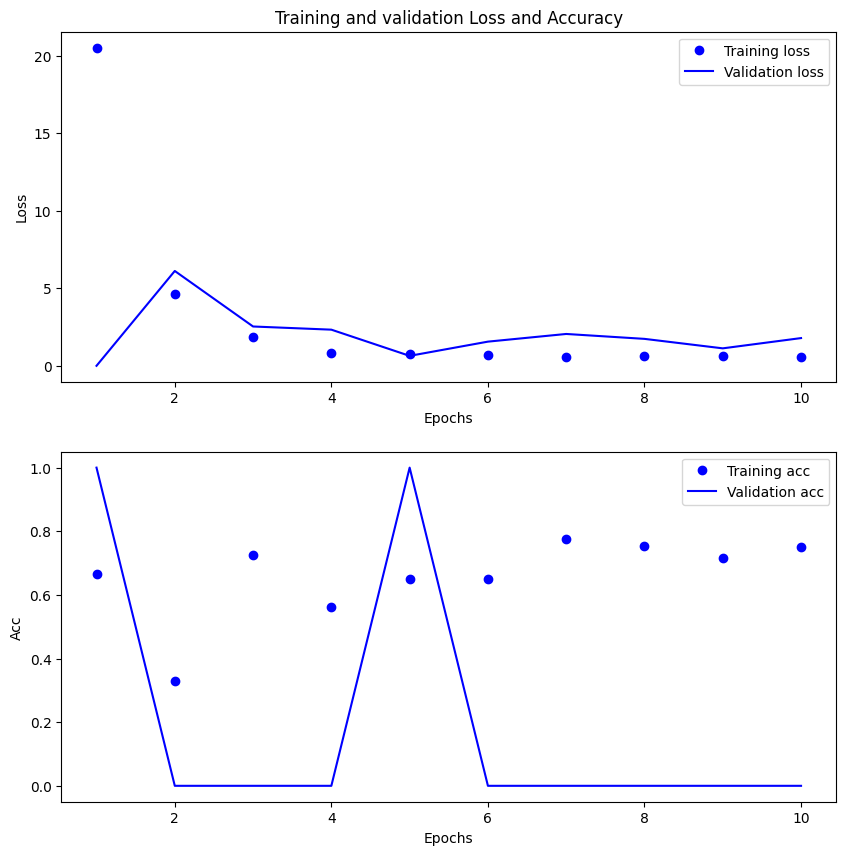

In [21]:
# Training curves
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [22]:
# Load the best saved model
from tensorflow.keras.models import load_model

model = load_model('model_efficientnetb0.h5')

In [23]:
# ‚úÖ Avaliando com o dataset de valida√ß√£o
score = model.evaluate(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

33/33 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 117s 3s/step - accuracy: 0.5819 - loss: 3.6554
Val loss: 6.492354869842529
Val accuracy: 0.2574162781238556


In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# üîπ Previs√µes do modelo (probabilidades)
predictions = model.predict(test_generator, verbose=1)

# üîπ R√≥tulos reais (inteiros)
true_labels = test_generator.classes

# üîπ Calcular acur√°cia (usando classe com maior probabilidade)
accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))
print(f"Test Accuracy: {accuracy:.4f}")

# üîπ Calcular AUC
# Para 2 classes, usa-se multi_class='ovr'
auc = roc_auc_score(true_labels, predictions[:,1], multi_class='ovr')
print(f"Test AUC: {auc:.4f}")

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 73s 4s/step
Test Accuracy: 0.3750
Test AUC: 0.7250


In [31]:
# Load the best saved model
from tensorflow.keras.models import load_model

model = load_model('model_resnet50.h5')

In [32]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1) Gerar previs√µes no conjunto de teste
# Se voc√™ j√° tiver y_pred pronto, pode pular esta parte
Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)  # classes previstas

# 2) Distribui√ß√£o das previs√µes
unique, counts = np.unique(y_pred, return_counts=True)
print("Distribui√ß√£o de previs√µes:", dict(zip(unique, counts)))

# 3) Relat√≥rio de classifica√ß√£o (sem warnings)
print(classification_report(
    test_generator.classes,   # classes verdadeiras
    y_pred,                   # classes previstas
    target_names=list(test_generator.class_indices.keys()),
    zero_division=0           # evita warnings, coloca 0.0 onde n√£o h√° previs√£o
))

# 4) (Opcional) Matriz de confus√£o
cm = confusion_matrix(test_generator.classes, y_pred)
print("Matriz de confus√£o:\n", cm)

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 177s 9s/step
Distribui√ß√£o de previs√µes: {np.int64(0): np.int64(624)}
              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624

Matriz de confus√£o:
 [[234   0]
 [390   0]]


Model: "sequential_5"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ efficientnetb0 (Functional)     ‚îÇ (None, 8, 8, 1280)     ‚îÇ     4,049,571 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d_1      ‚îÇ (None, 1280)           ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_10 (Dense)                ‚îÇ (None, 256)            ‚îÇ       327,936 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_11 (Dense)                ‚îÇ (None, 2)              ‚îÇ           514 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4s/step - accuracy: 0.6706 - loss: 0.6854
Epoch 1: val_loss improved from inf to 1.39917, saving model to model_efficientnetb0.h5


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 51s 6s/step - accuracy: 0.6767 - loss: 0.6797 - val_accuracy: 0.0000e+00 - val_loss: 1.3992
Epoch 2/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4s/step - accuracy: 0.7842 - loss: 0.5298
Epoch 2: val_loss improved from 1.39917 to 1.37085, saving model to model_efficientnetb0.h5


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 7s/step - accuracy: 0.7815 - loss: 0.5332 - val_accuracy: 0.0000e+00 - val_loss: 1.3709
Epoch 3/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4s/step - accuracy: 0.7711 - loss: 0.5480
Epoch 3: val_loss improved from 1.37085 to 1.34983, saving model to model_efficientnetb0.h5


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 5s/step - accuracy: 0.7703 - loss: 0.5491 - val_accuracy: 0.0000e+00 - val_loss: 1.3498
Epoch 4/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3s/step - accuracy: 0.6751 - loss: 0.6387
Epoch 4: val_loss improved from 1.34983 to 1.11332, saving model to model_efficientnetb0.h5


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 8s/step - accuracy: 0.6761 - loss: 0.6371 - val_accuracy: 0.0000e+00 - val_loss: 1.1133
Epoch 5/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4s/step - accuracy: 0.7674 - loss: 0.5615
Epoch 5: val_loss did not improve from 1.11332
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 8s/step - accuracy: 0.7635 - loss: 0.5644 - val_accuracy: 0.0000e+00 - val_loss: 1.3875
Epoch 6/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4s/step - accuracy: 0.7312 - loss: 0.5885
Epoch 6: val_loss improved from 1.11332 to 0.88436, saving model to model_efficientnetb0.h5


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42s 8s/step - accuracy: 0.7257 - loss: 0.5946 - val_accuracy: 0.0000e+00 - val_loss: 0.8844
Epoch 7/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4s/step - accuracy: 0.7346 - loss: 0.6235
Epoch 7: val_loss did not improve from 0.88436
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 7s/step - accuracy: 0.7346 - loss: 0.6225 - val_accuracy: 0.0000e+00 - val_loss: 1.7383
Epoch 8/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4s/step - accuracy: 0.7662 - loss: 0.5437
Epoch 8: val_loss did not improve from 0.88436
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 7s/step - accuracy: 0.7632 - loss: 0.5494 - val_accuracy: 0.0000e+00 - val_loss: 1.4147
Epoch 9/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3s/step - accuracy: 0.7475 - loss: 0.5959
Epoch 9: val_loss did not improve from 0.88436
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

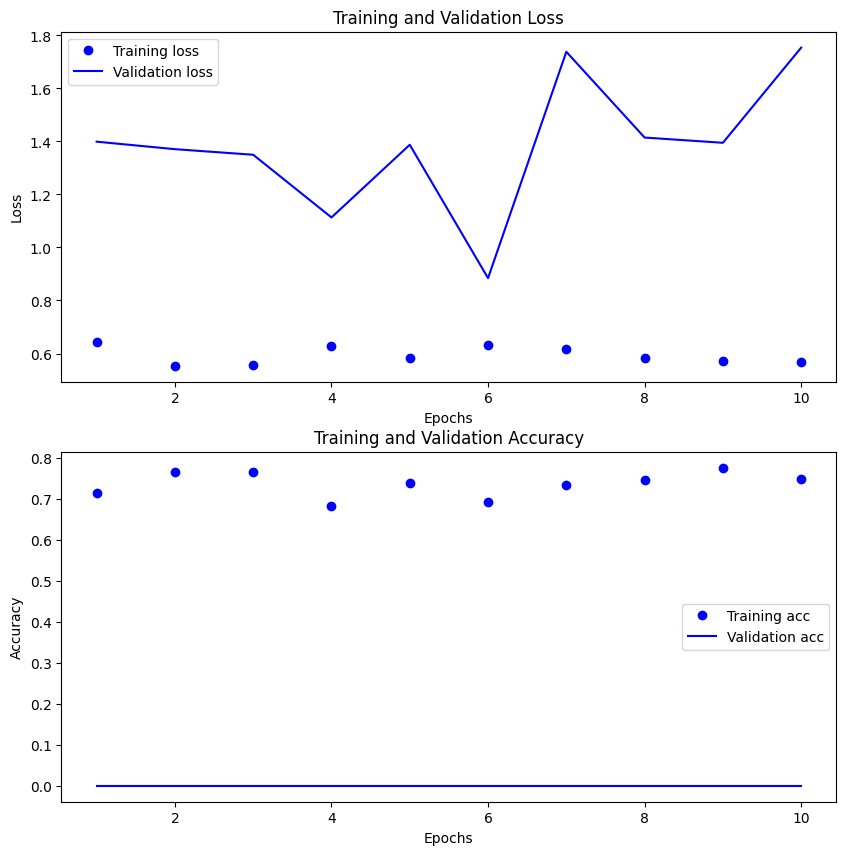

33/33 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 115s 3s/step - accuracy: 0.4181 - loss: 0.6972
Val loss: 0.682188093662262
Val accuracy: 0.7425837516784668
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 70s 3s/step
Test Accuracy: 0.6250
Test AUC: 0.5986
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 68s 3s/step


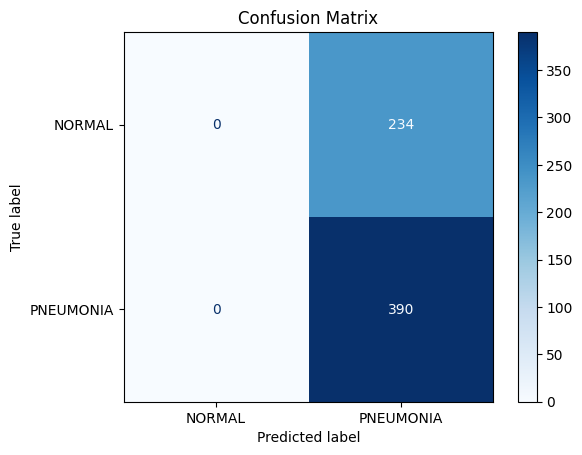

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



In [30]:
# ‚úÖ Modelo com EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow import keras

# üîπ Carregar EfficientNetB0 pr√©-treinada
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# üîπ Criar modelo sequencial
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # üîÑ melhor que Flatten para EfficientNet
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')  # üîÑ 2 classes com softmax
])

# üîπ Congelar camadas da EfficientNet
for layer in base_model.layers:
    layer.trainable = False

# üîπ Compilar modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# üîπ Defini√ß√£o de par√¢metros
epochs = 10

# üîπ Callbacks
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model_efficientnetb0.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1
    )
]

# üöÄ Treinamento
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // BATCH_SIZE,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // BATCH_SIZE,
    verbose=1
)

# üìâ Curvas de treinamento
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# ‚úÖ Carregar melhor modelo salvo
from tensorflow.keras.models import load_model
model = load_model('model_efficientnetb0.h5')

# üîπ Avalia√ß√£o no conjunto de valida√ß√£o
score = model.evaluate(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

# ‚úÖ Teste com m√©tricas extras
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# Previs√µes no teste
predictions = model.predict(test_generator, verbose=1)
true_labels = test_generator.classes

# Acur√°cia
accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))
print(f"Test Accuracy: {accuracy:.4f}")

# AUC
auc = roc_auc_score(true_labels, predictions[:,1])
print(f"Test AUC: {auc:.4f}")

# ‚úÖ Relat√≥rios
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Nomes das classes
target_names = list(test_generator.class_indices.keys())

# Matriz de confus√£o
cm = confusion_matrix(test_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report")
print(classification_report(test_generator.classes, y_pred, target_names=target_names, zero_division=0))


Model: "sequential_7"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ resnet50 (Functional)           ‚îÇ (None, 8, 8, 2048)     ‚îÇ    23,587,712 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d_2      ‚îÇ (None, 2048)           ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_14 (Dense)                ‚îÇ (None, 256)            ‚îÇ       524,544 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_15 (Dense)                ‚îÇ (None, 2)              ‚îÇ           514 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8s/step - accuracy: 0.8036 - loss: 0.9933
Epoch 1: val_loss improved from inf to 0.31348, saving model to model_resnet50.h5


6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 75s 11s/step - accuracy: 0.7997 - loss: 1.0061 - val_accuracy: 1.0000 - val_loss: 0.3135
Epoch 2/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8s/step - accuracy: 0.4332 - loss: 0.8094
Epoch 2: val_loss did not improve from 0.31348
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 82s 15s/step - accuracy: 0.4584 - loss: 0.7930 - val_accuracy: 0.0000e+00 - val_loss: 3.0919
Epoch 3/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8s/step - accuracy: 0.6594 - loss: 0.8151
Epoch 3: val_loss did not improve from 0.31348
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 81s 15s/step - accuracy: 0.6431 - loss: 0.8138 - val_accuracy: 1.0000 - val_loss: 0.6294
Epoch 4/10
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8s/step - accuracy: 0.8121 - loss: 0.5873
Epoch 4: val_loss did not improve from 0.31348
6/6 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

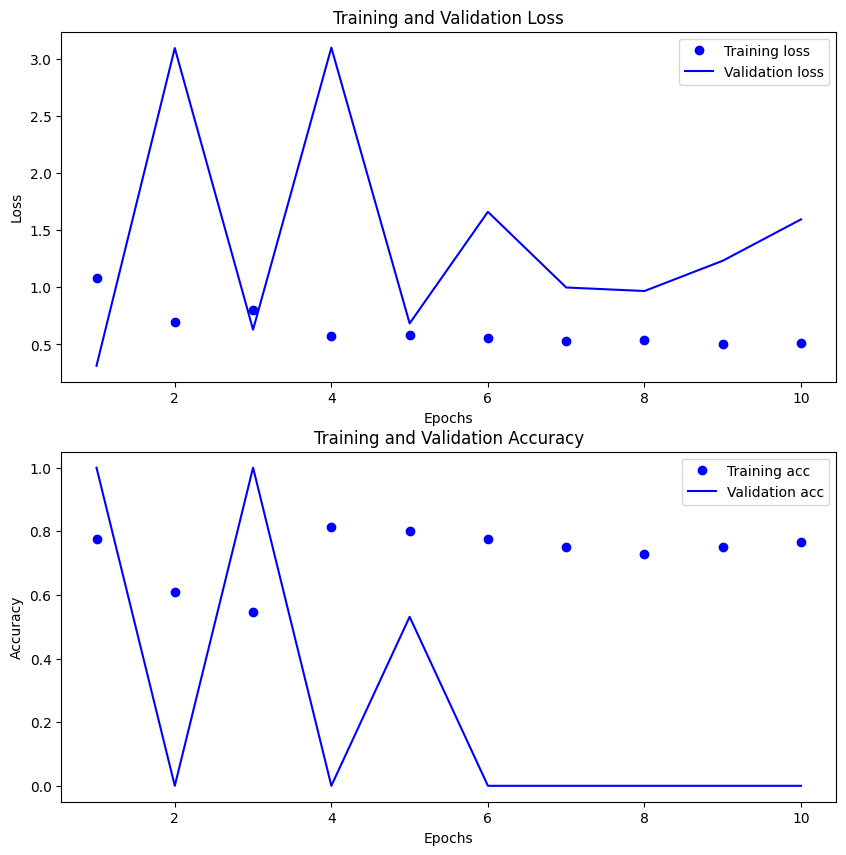

33/33 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 266s 8s/step - accuracy: 0.5819 - loss: 0.7133
Val loss: 1.0239813327789307
Val accuracy: 0.2574162781238556
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 163s 8s/step
Test Accuracy: 0.3750
Test AUC: 0.7775
20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 166s 8s/step


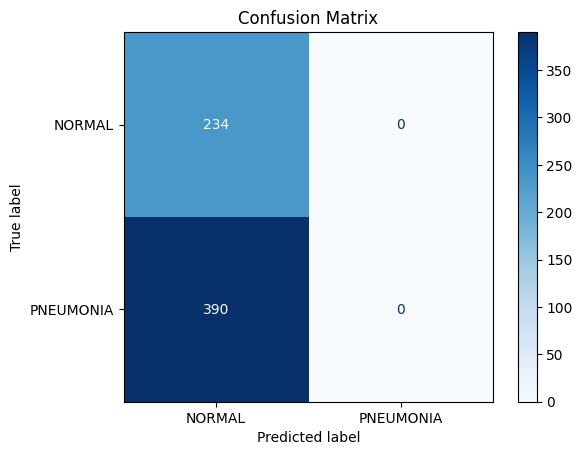

Classification Report
              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



In [36]:
# ‚úÖ Modelo com ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

# üîπ Carregar ResNet50 pr√©-treinada
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# üîπ Criar modelo sequencial
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # üîÑ mais eficiente que Flatten
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')  # üîÑ 2 classes com softmax
])

# üîπ Congelar camadas da ResNet50
for layer in base_model.layers:
    layer.trainable = False

# üîπ Compilar modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# üîπ Defini√ß√£o de par√¢metros
epochs = 10

# üîπ Callbacks
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model_resnet50.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1
    )
]

# üöÄ Treinamento
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // BATCH_SIZE,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // BATCH_SIZE,
    verbose=1
)

# üìâ Curvas de treinamento
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ‚úÖ Carregar melhor modelo salvo
model = load_model('model_resnet50.h5')

# üîπ Avalia√ß√£o no conjunto de valida√ß√£o
score = model.evaluate(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

# ‚úÖ Teste com m√©tricas extras
predictions = model.predict(test_generator, verbose=1)
true_labels = test_generator.classes

# Acur√°cia
accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))
print(f"Test Accuracy: {accuracy:.4f}")

# AUC
auc = roc_auc_score(true_labels, predictions[:,1])
print(f"Test AUC: {auc:.4f}")

# ‚úÖ Relat√≥rios
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = list(test_generator.class_indices.keys())

# Matriz de confus√£o
cm = confusion_matrix(test_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report")
print(classification_report(test_generator.classes, y_pred, target_names=target_names, zero_division=0))
